In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [2]:
X_train=np.load("../data/X_train.npy")
y_train=np.load("../data/y_train.npy")

X_val=np.load("../data/X_val.npy")
y_val=np.load("../data/y_val.npy")

X_test=np.load("../data/X_test.npy")
y_test=np.load("../data/y_test.npy")

In [3]:
X = np.concatenate((X_train, X_val, X_test), axis = 0)
y = np.concatenate((y_train, y_val, y_test), axis = 0)

In [98]:
Xbeatles = np.load('../data/X_Beatles.npy')[0]

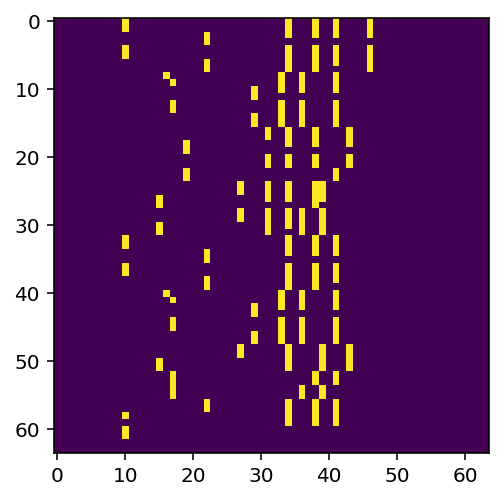

In [105]:
plt.imshow(Xbeat)

In [109]:
Xbeat.shape

(64, 64)

In [104]:
Xbeat = Xbeatles[:, 5:69]

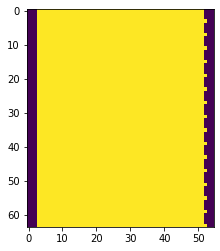

In [5]:
Xa = X[ : , : , 12:67 ]
plt.imshow(np.sum(Xa, axis= 0)>0)

(8544, 64, 64)

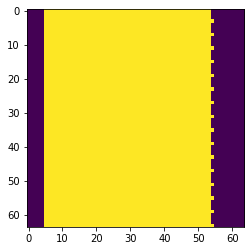

In [6]:
Xtrunc = X[ : , : , 10:74 ]
plt.imshow(np.sum(Xtrunc, axis= 0)>0)
Xtrunc.shape

In [7]:
ytrunc = y[: , : , 10:74]
ytrunc.shape

(8544, 16, 64)


### Multi-head attention

In [8]:
def scaled_dot_product_attention(q, k, v, mask):
    """
Calculate the attention weights.
    q, k, v must have matching leading dimensions ----> dimension of vector representation.
    DEGREES OF LIBERTY OF THE MODEL -----> the parameters of the q matrix (q for 'query')
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v -----> "length" of the input if length q diff (shorter) from k/v: you will 
    consider only the q first notes (vectors)
    The mask has different shapes depending on its type(padding or look ahead) -----> if you want to consider some of the data only
    but it must be broadcastable for addition (maybe not that useful in our case)

Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

Returns
    output : a representation of the vectors weighted appropriately
    attention_weights : the sofmaxed products of qk: represents the "weights" that will be attributed to each feature of v.
  """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

      # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

      # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) #large negative values ensure that the gradient stays shit(~zero)

      # softmax is normalized on the last axis (seq_len_k) so that the scores
      # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    '''
    Multihead attention is just attention applied to a linear combo of the depths:
    the output is then the same linear combo of outputs. 
    The goal is then to reduce this d_model by 'packing' dimensions together. 
    We perform uniform separation ('batches' of dimensions have the same size,
    which is called `num_heads` below), then get the final output by concatenation.
    DEGREES OF LIBERTY: parameters of the linear combo
    '''
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model) #The goal here is to create linear combo of the features

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        batch_size: first dim (the range of notes) can also be split as we saw during lectures
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0] # the batch size is indeed the shape of the q, which is the 'lookup' function

        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

### Feed Fwd netword

In [10]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### Masks

#### Padding mask

In [11]:
def spot_zerovectors(music_input, num_heads):
    
    batch_s_ = music_input.shape[0]
    input_length = music_input.shape[1]
    
    input_split = tf.reshape(music_input, (batch_s_, input_length, num_heads, -1))
    input_split = tf.transpose(input_split, perm=[0, 2, 1, 3]) #(batch_size, num_heads, seq_length, depth)
    bool_matrix = tf.math.equal(input_split, 0)
    zerovectors = tf.cast(tf.reduce_all(bool_matrix, axis=-1), dtype='float') #(batch_size, num_heads, seq_length)
    return zerovectors

In [12]:
spot_zerovectors(Xtrunc[0:10], 8).shape

TensorShape([10, 8, 64])

In [13]:
'''
Mask all the pad tokens in the batch of sequence. 
It ensures that the model does not treat padding as the input. 
The mask indicates where pad value 0 is present: 
it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(music_input, music_output, num_heads): #ignore all zeros vectors 
   
    zero_vectors = spot_zerovectors(music_input, num_heads)
    output_length = music_output.shape[1]
    
    return tf.repeat(zero_vectors[:, :, tf.newaxis, :], output_length, axis=-2) #(batch_size, num_heads, tar_seq_length, inp_seq_length)

In [14]:
create_padding_mask(Xtrunc[0:10], Xtrunc[0:10], 8).shape

TensorShape([10, 8, 64, 64])

#### Look-ahead mask

In [15]:
'''
The look-ahead mask is used to mask the future tokens in a sequence. 
In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the 
first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.
'''

def create_look_ahead_mask(batch_size, size, num_heads):
    '''
    Consider only the notes before the one considered
    '''    
   
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    mask = tf.repeat(mask[tf.newaxis, :, :], num_heads, axis=0) 
    return tf.repeat(mask[tf.newaxis, :, :, :], batch_size, axis=0)# (batch_size, num_heads, seq_len, seq_len)

#### Self-attention decoder mask

In [16]:
def self_attention_decoder_mask(music_input, num_heads):
    
    padding_mask = create_padding_mask(music_input, music_input, num_heads)
    
    size = music_input.shape[1] 
    batch_s = music_input.shape[0]
    
    look_ahead_mask = create_look_ahead_mask(batch_s, size, num_heads)
    
    return tf.cast(look_ahead_mask + padding_mask > 0, dtype='float')

### Positional encoding (using cosine)

adding to features to get shape(64, 212)
PE(i, 2j) = sin(i/(10000^(2j/dmodel))
PE(i, 2j) = cos(i/(10000^(2j/dmodel))

In [17]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
    '''
    from a list of position [0 to length -1] build the the pos encoding,
    DOUBLING THE LENGTH
    '''
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# Encoder

***now we're talking***

### Encoder layer

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    '''
    one block of encoder
    '''
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.num_heads = num_heads

    def call(self, x, training):

        attn_output, _ = self.mha(x, x, x, create_padding_mask(x, x, self.num_heads))  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

### Full encoder (with preprocessing)

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        

    def call(self, x, training):

        seq_len = tf.shape(x)[1]

        x = tf.cast(x, tf.float32)
        # normalizing for model 'depth'
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # adding positional encoding.
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)

        return x  # (batch_size, input_seq_len, d_model)

# Decoder

## Decoder layer

In [21]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        self.num_heads = num_heads

    def call(self, x, enc_output, training):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x,
                                              self_attention_decoder_mask(x, self.num_heads) 
                                              )
        # (batch_size, target_seq_len, d_model)
        # first mha layer acts on the outputs
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
                                            out1, enc_output, enc_output, 
                                            create_padding_mask(enc_output, out1, self.num_heads))  # (batch_size, target_seq_len, d_model)
        # second mha layer: key, queries from the encoder, values itself
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Full decoder

1 postional layer, N decoding layers

In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

       
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        #for us d_model = 64
        x = tf.cast(x, tf.float32) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Plugging everything, plus sigmoid layer

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                  pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               pe_target, rate)

        self.final_layer = tf.keras.layers.Activation('sigmoid') #already the correct shape youhou

    def call(self, input_enc, input_dec,  training):
        # Keras models prefer if you pass all your inputs in the first argument

        enc_output = self.encoder(input_enc, training)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(input_dec, enc_output, training) #

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

# Train, compile, stuff

### Hyperparameters

In [24]:
num_layers = 4
d_model = 64 #d_model is our number of features, SO DO NOT CHANGE THAT
dff = 2048
num_heads = 8 #must be a divider of d_model, so not a lot of choices here...
dropout_rate = .1

### Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
# learning rate will increase linearly over the warmup_steps, the decrease like    
# the inverse square root
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

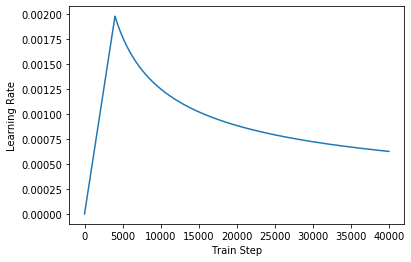

In [26]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss and metrics

In [27]:
def gkern(height, width):
    
    sigx = tf.cast(height/6, 'float')
    sigy = tf.cast(width/6, 'float')
    ay = tf.linspace(-(width - 1) / 2., (width - 1) / 2., width)
    ax = tf.linspace(-(height - 1) / 2., (height - 1) / 2.,height)
    gaussx = tf.math.exp(-0.5 * tf.math.square(ax) / tf.math.square(sigx))
    gaussy = tf.math.exp(-0.5 * tf.math.square(ay) / tf.math.square(sigy))
    kernel = tf.tensordot(gaussx, gaussy, axes=0)
    
    return kernel / tf.reduce_sum(kernel)


def batch_convolute(X, ker): #convolute over a pile of images

    ker = tf.expand_dims(tf.expand_dims(ker, axis=-1), axis=-1)
    X = tf.cast(X, dtype='float')
    X = tf.expand_dims(X, axis=-1)
    ans =  tf.nn.conv2d(X, ker, strides = [1,1,1,1], padding='SAME')

    return tf.squeeze(ans)


def custom_metrics(y_true, y_pred, kernel_height=10, kernel_width=10):

    ker = gkern(kernel_height, kernel_width)

    y_true = batch_convolute(y_true, ker)
    y_pred = batch_convolute(y_pred, ker)

    return 1 - tf.reduce_sum(tf.math.abs(y_true-y_pred))/tf.reduce_sum(y_true+y_pred)


  
def simple2D_convolute(A, ker):
    
    ker = tf.expand_dims(tf.expand_dims(ker, axis=-1), axis=-1)
    A = tf.expand_dims(tf.expand_dims(A, axis=0), axis=-1)
    A = tf.cast(A, dtype='float')
    ans =  tf.nn.conv2d(A, ker, strides = [1,1,1,1], padding='SAME')

    return tf.squeeze(ans)

bce = tf.keras.losses.BinaryCrossentropy()

def custom_loss(y_true, y_pred, ker_height=3, ker_width=2): #we want to calcute over a batch

    #ker = gkern(ker_height, ker_width)
    #y_true = tf.cast(y_true, dtype='float')
    #y_pred = batch_convolute(y_pred, ker)
    
    #coeffs = tf.reduce_sum(y_true, (1,2))/tf.reduce_sum(y_pred, (1,2))
    #y_pred = coeffs[:, tf.newaxis, tf.newaxis] * y_pred

    return  bce(y_true, y_pred)#tf.reduce_mean(tf.math.abs(y_true - y_pred))

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Train

### Train step and # of epochs

In [29]:
EPOCHS = 250

In [30]:
def train_step(inp, tar):
    # here we want to compare the transformer ouput with the target: we will shift right to feed the decoder,
    # compare trans output with tar shft left (since the decoder DO NOT change the length of the extract)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar[:, :-1, :],
                                 training = True)
      
        loss = custom_loss(tar[:, 1:, :], predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(custom_metrics(tar[:, 1:, :], predictions))

In [31]:
A = [1,2,3,4,5]
A[1:]

[2, 3, 4, 5]

### Batching the dataset

In [32]:
BATCH_SIZE = 32

In [33]:
def train_batches(X, y, batch_size=BATCH_SIZE):
    n_samples = X.shape[0]
    list_ = list(range(n_samples))
    random.shuffle(list_)
    
    n_batches = n_samples // batch_size
    ans = []
    
    for i in range(n_batches):
        
        Xbatch = np.zeros((batch_size, X.shape[1], X.shape[2]))
        ybatch = np.zeros((batch_size, y.shape[1], y.shape[2]))
        for j in range(0, batch_size):
            
            Xbatch[j, :, :] = X[list_[j + i * batch_size], :, :]
            ybatch[j, :, :] = y[list_[j + i * batch_size], :, :]
        ans.append((Xbatch, ybatch))
    len_last_batch = n_samples % batch_size
    if len_last_batch != 0:
        Xbatch = np.zeros((len_last_batch, X.shape[1], X.shape[2]))
        ybatch = np.zeros((len_last_batch, y.shape[1], y.shape[2]))
        for i in range(len_last_batch):
            Xbatch[i, :, :] = X[list_[batch_size * (n_samples // batch_size) + i], :, :]
            ybatch[i, :, :] = y[list_[batch_size * (n_samples // batch_size) + i], :, :]
        ans.append((Xbatch, ybatch))
    return ans    

In [34]:
len(train_batches(X_train, y_train)[193][0])

32

### Training itself

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

For example, sentence = "SOS A lion in the jungle is sleeping EOS"

tar_inp = "SOS A lion in the jungle is sleeping"

tar_real = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each token, self-attention allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [35]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [36]:
checkpoint_path = "./checkpoints/train"
#
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
#
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
#
## if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [37]:
'''
NOW WE TRAIN
'''

for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    


    for (batch, (inp, tar)) in enumerate(train_batches(Xtrunc, ytrunc)):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1 Batch 0 

KeyboardInterrupt: 

# Interpreter

In [82]:
class Musician(tf.Module):
    def __init__(self, transformer, output_length):
        #self.tokenizers = tokenizers
        self.transformer = transformer
        self.output_length = output_length
        
    def __call__(self, music):
    
  
        encoder_input = tf.expand_dims(music, 0)
        
        
        #decoder initializing with the last note heard
        
        
        decoder_input = encoder_input[:, -1:, :]
    
        for i in range(self.output_length):
            
            predictions, _ = self.transformer(encoder_input, decoder_input, training=False)
            next_note = notes(tf.squeeze(predictions[:, -1, :]))
            decoder_input = np.concatenate((decoder_input, next_note[tf.newaxis, tf.newaxis, :]), axis=1)
            
               
        return np.squeeze(decoder_input[:, 1:, :])


In [ ]:
class Dummy(tf.Module):
    def __init__(self, transformer, output_length):
        #self.tokenizers = tokenizers
        self.transformer = transformer
        self.output_length = output_length
        
    def __call__(self, music):
    
    

In [79]:
musician = Musician(transformer,15)

In [54]:
musician(Xtrunc[34])

<tf.Tensor: shape=(50, 64), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

# Converting probas to notes (per time step)

In [ ]:
A = tf.reduce_sum(Xtrunc, -1) # shape (batch_size, len_seq)
tf.reduce_max(A)

In [ ]:
Xtrunc[0,0,:].shape[0]

In [ ]:
len(np.where(A == 10)[0])

In [41]:
def notes(prob_notes): # shape(d_model)
    
    range_notes = prob_notes.shape[0]    
    high_prob = tf.reduce_max(prob_notes)
    
      
    ans = tf.cast((prob_notes > high_prob/2), dtype='float')
    ans = ans.numpy()
    #we want to eliminate disgracious contiguous notes
    
    #one_indices = np.where(ans == 1)[0]

    #for i in range(1, len(one_indices)):
    #    if one_indices[i] - one_indices[i -1] == 1:
    #        ans[one_indices[i]] = 0
    
    return ans
        

In [ ]:
notes_prob = np.array([.1, .6, .7, .8, .9, .5, .54545, .6, .67, .57, .75])
len(notes_prob)

In [ ]:
notes(notes_prob)

In [ ]:
one_indices

In [ ]:
one_indices = np.where(notes(notes_prob) == 1)[0]

In [ ]:
for i in range(1, len(one_indices)):
    if one_indices[i] - one_indices[i -1] == 1:
        print('ok')
        A[one_indices[i]] = 0

In [57]:
from PIL import Image

In [50]:
!pip install imageio

     |████████████████████████████████| 3.3MB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 3.1MB 8.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [48]:
!pip install music21

     |████████████████████████████████| 19.3MB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 7.1MB/s eta 0:00:01
  Created wheel for music21: filename=music21-6.7.1-cp36-none-any.whl size=21939371 sha256=9dd40024913eb4da711b80ef0dff0cebca75eff0b2882d75929ec71ad1eb6827
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
You should consider upgrading via the 'pip install --upgrade pip' command.


In [51]:
from music21 import instrument, note, chord, stream
from imageio import imwrite
### Matrix to image section

lowerBoundNote = 21

def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

def updateNotes(newNotes,prevNotes, resolution):
    res = {}
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path, resolution):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{},resolution)
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes, resolution)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes, resolution)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

def matrix_to_image(matrix, file_name):
    '''
    Convert numpy array to midi image
    '''
    matrix_bw = matrix
    matrix_bw[matrix_bw > 0] = 255 # change 1 to white pixel
    imwrite(file_name + ".png", matrix_bw.astype(np.uint8))

def matrix_to_midi(matrix, file_name, resolution):
    '''
    Create midi_file out of matrix
    '''
    matrix_to_image(matrix, file_name)
    image2midi(file_name + '.png', resolution)

In [83]:
def composer(musician, music_input, n_measures):
    musician_input = music_input
    for i in range(n_measures):
        next_measure = musician(musician_input)
        musician_input = tf.concat([musician_input, next_measure], axis=0)
    return musician_input

In [87]:
B = composer(musician, Xtrunc[8000], 10)

In [106]:
C = composer(musician, Xbeat, 10)

In [80]:
A = musician(Xtrunc[8000])

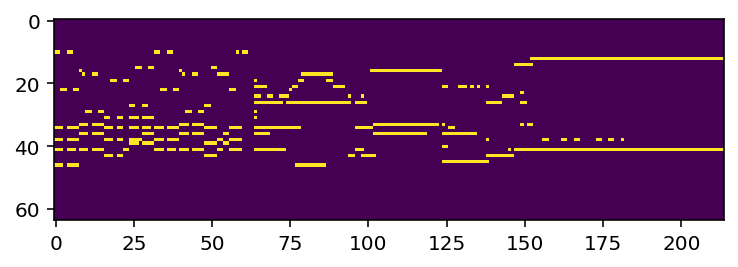

In [107]:
plt.imshow(C.numpy().T)

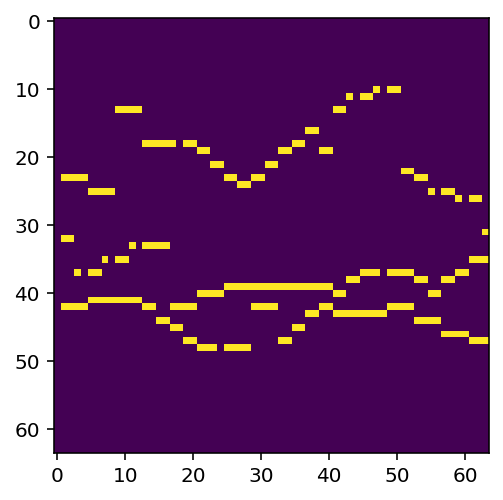

In [67]:
plt.imshow(Xtrunc[1000].T)

In [108]:

matrix_to_midi(C.numpy().T, 'Etienne7', .25)

In [59]:
pwd

'/tf/bach_propagation/notebooks'

In [ ]:
plt.imshow(X_train[123])

In [ ]:
BOL = np.array([[True, True, False],[False, False, True]])
BOL.astype('int')

In [ ]:
def composer(transformer, music_input, output_length):
    
    return 'Abject Failure !'



In [ ]:
(notes(musician2(Xtrunc[10]), Xtrunc[10]))

In [ ]:
plt.imshow(Xtrunc[10])

In [ ]:
A = composer(transformer, X_train[123], 50)

In [ ]:
from utils import plot_midi

In [ ]:
plt.imshow(A)

In [ ]:
plt.imshow(X_train[123])